# SIGCUP 23

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Data_UMD/SIGCUP23_Ice/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1L50GG4BeHtlJpoHwRgy0dxyVosrQvc1n/SIGCUP23_Ice


In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import tensorflow as tf

In [2]:
GPU_IDX = 1 # 0 or 1
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[GPU_IDX], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[GPU_IDX], True)
        visible_gpus = tf.config.get_visible_devices('GPU')
        print("Physical GPUs = ", len(gpus), "\nVisivle GPU is used to ", gpus[GPU_IDX])
    except RuntimeError as e:
        print(e)

Physical GPUs =  2 
Visivle GPU is used to  PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

INPUT_X_CHANNEL = 3
INPUT_Y_CHANNEL = 2
OUTPUT_CHANNEL = 2

BATCH_SIZE = 20

DIR_INPUT = os.path.join('TrainData', 'TFR')
DIR_OUTPUT = 'Result'


# Train


In [4]:
def input_pipeline(filename, batch_size, is_train=True, is_shuffle=True, is_stand=False):
    feature_description = {
        'label': tf.io.VarLenFeature(tf.float32),
        'image': tf.io.VarLenFeature(tf.float32),
    }


    def _augTrain(img_and_label):
        img_and_label = tf.image.rot90(img_and_label, tf.random.uniform([], 0, 4, dtype=tf.int32))
        img_and_label = tf.image.random_flip_left_right(img_and_label)
        img_and_label = tf.image.random_flip_up_down(img_and_label)

        return img_and_label


    def _process_train(inp_img, inp_label):
        # augment
        img_and_label = tf.concat([inp_img, inp_label], axis=-1)
        img_and_label = _augTrain(img_and_label)

        inp_img = img_and_label[...,:inp_img.shape[-1]]
        inp_label = img_and_label[...,inp_img.shape[-1]:]

        # standarlization
        if is_stand:
            inp_img= tf.image.per_image_standardization(inp_img)

        return inp_img, inp_label


    def _process_test(inp_img):
        # standarlization
        if is_stand:
            inp_img= tf.image.per_image_standardization(inp_img)

        return inp_img


    def _parse_function(example_proto):
        feature_dict = tf.io.parse_single_example(example_proto, feature_description)

        image = tf.sparse.to_dense(feature_dict['image'], default_value=0)
        image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, INPUT_X_CHANNEL])

        label = tf.sparse.to_dense(feature_dict['label'], default_value=0)
        label = tf.reshape(label, [IMG_HEIGHT, IMG_WIDTH, INPUT_Y_CHANNEL])


        if is_train:
            image, label = _process_train(image, label)
        else:
            image = _process_test(image)


        label = tf.cast(label, tf.int32)
        mask = tf.cast(label[:,:,1:], tf.float32)
        label = tf.one_hot(label[:,:,0], depth=OUTPUT_CHANNEL)
        label = tf.concat([label, mask], axis=-1)

        return image, label

    dataset = tf.data.TFRecordDataset(filename)
    # dataset = dataset.cache()
    # if is_repeat:
    #     dataset = dataset.repeat()
    if is_shuffle:
        dataset = dataset.shuffle(buffer_size=2000)
    batch = (
        dataset
        .map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE))

    return batch


def downsampling(filters, size, norm_type='batchnorm'):
    res = tf.keras.Sequential()
    res.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                                    #   activation=tf.nn.relu,
                                      use_bias=True))
    res.add(tf.keras.layers.BatchNormalization())
    res.add(tf.keras.layers.LeakyReLU())
    res.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                    #   activation=tf.nn.relu,
                                      use_bias=True))
    res.add(tf.keras.layers.BatchNormalization())
    res.add(tf.keras.layers.LeakyReLU())
    return res


def upsampling(filters, size, norm_type='batchnorm'):
    res = tf.keras.Sequential()
    res.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',
                                        # activation=tf.nn.relu,
                                        use_bias=True))
    res.add(tf.keras.layers.BatchNormalization())
    res.add(tf.keras.layers.LeakyReLU())
    res.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                                    #   activation=tf.nn.relu,
                                      use_bias=True))
    res.add(tf.keras.layers.BatchNormalization())
    res.add(tf.keras.layers.LeakyReLU())
    return res


def unet(norm_type='batchnorm'):
    # 1. maxpooling will reduce some grid effects in UNet
    # 2. cannot add raw image directly back to last convTranspose
    #  needs to add features
    down_stack = [
        downsampling(16, 3, norm_type),  # (bs, 64, 64, 16)
        downsampling(32, 3, norm_type),  # (bs, 32, 32, 32)
        downsampling(64, 3, norm_type),  # (bs, 16, 16, 64)
    ]

    up_stack = [
        upsampling(32, 3, norm_type),  # (bs, 32, 32, 32)
        upsampling(16, 3, norm_type),  # (bs, 64, 64, 16)
    ]

    x_trans = upsampling(INPUT_X_CHANNEL, 3, norm_type) # (bs, 128, 128, INPUT_X_CHANNEL)


    # Image feature transform
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, INPUT_X_CHANNEL])
    x = inputs


    # UNet Flow
    skips = []

    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = x_trans(x)

    x = tf.keras.layers.Concatenate()([x, inputs])

    # Output
    m_out = tf.keras.Sequential()
    m_out.add(tf.keras.layers.Conv2D(32, 1, strides=1, padding='same',
                                    activation=tf.nn.relu))
    m_out.add(tf.keras.layers.Conv2D(32, 1, strides=1, padding='same',
                                    activation=tf.nn.relu))
    m_out.add(tf.keras.layers.Conv2D(OUTPUT_CHANNEL, 1, strides=1, padding='same'))

    output = m_out(x)

    return tf.keras.Model(inputs=inputs, outputs=output)


def computeF1Score(label_list, logits_list):
    ep = 1e-8

    label_list_ = tf.concat(label_list, axis=0)
    logits_list_ = tf.concat(logits_list, axis=0)

    y_true_class = tf.cast(label_list_[...,-1], tf.float32)
    y_pred_class = tf.cast(tf.math.argmax(logits_list_, axis = -1), tf.float32)

    tp = tf.reduce_sum(y_true_class * y_pred_class)
    tall = tf.reduce_sum(y_true_class) + ep
    pall = tf.reduce_sum(y_pred_class) + ep

    p_print = (tp / pall).numpy() + ep
    r_print = (tp / tall).numpy() + ep

    test_f1 = 2/(p_print**-1 + r_print**-1)

    return p_print, r_print, test_f1


@tf.function
def dice_loss(y_true, y_pred):
    ep = 1e-8
    # usually tf.one_hot() converts 0 to dim 0 while 1 to dim 1
    # if the input are 0, 1,2, etc...
    intersection = 2 * tf.reduce_sum(y_pred[...,1] * y_true[...,1]) + ep

    # times 2 : for emphasizing recall (usually recall is smaller than pre)
    union = 2 * tf.reduce_sum(y_pred[...,1]) + tf.reduce_sum(y_true[...,1]) + ep
    loss = 1 - intersection / union
    return loss


@tf.function
def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    loss = -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1 + 1e-8)) \
            -tf.reduce_sum((1-alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0 + 1e-8))
    return loss


In [5]:
@tf.function
def train_step(tf_model, tf_opmz, train_img, train_lab):
    with tf.GradientTape() as u_tape:
        logits = tf_model(train_img, training=True)
        logits = logits * train_lab[...,OUTPUT_CHANNEL:]
        logits = tf.nn.softmax(logits)
        loss = dice_loss(train_lab[...,:OUTPUT_CHANNEL], logits)

    grad_u_model = u_tape.gradient(loss, tf_model.trainable_variables)
    tf_opmz.apply_gradients(zip(grad_u_model, tf_model.trainable_variables))
    return logits, [loss]

@tf.function
def test_step(tf_model, test_img, test_lab):
    logits = tf_model(test_img, training=False)
    logits = tf.nn.softmax(logits)
    return logits * test_lab[...,OUTPUT_CHANNEL:]

def computeKerasF1Score(tp, fp, fn):
    np_pre = tp.result() / (tp.result() + fp.result())
    np_rec = tp.result() / (tp.result() + fn.result())
    np_f1 = 2 * (np_pre * np_rec) / (np_pre + np_rec)

    return np_f1.numpy(), np_pre.numpy(), np_rec.numpy()


def train_test_step(tf_model, tf_opmz, tf_ckp, output_ckp, train_path, test_path, epoch):
    t_s = time.time()
    res_acc = [epoch+1]

    train_batch = input_pipeline(train_path, BATCH_SIZE, is_train=True, is_shuffle=True, is_stand=True)
    test_batch = input_pipeline(test_path, BATCH_SIZE, is_train=False, is_shuffle=True, is_stand=True)

    # train
    train_acc = tf.keras.metrics.CategoricalAccuracy()
    train_tp = tf.keras.metrics.TruePositives()
    train_fp = tf.keras.metrics.FalsePositives()
    train_fn = tf.keras.metrics.FalseNegatives()

    train_loss = []
    for train_img, train_lab in train_batch:
        logits, cur_loss = train_step(tf_model, tf_opmz, train_img, train_lab)

        train_lab = train_lab[...,-2]
        logits = tf.cast(tf.math.argmax(logits, axis = -1), tf.float32)

        train_acc.update_state(train_lab, logits)
        train_tp.update_state(train_lab, logits)
        train_fp.update_state(train_lab, logits)
        train_fn.update_state(train_lab, logits)
        
        train_loss.append(cur_loss)

    train_loss = tf.concat(train_loss, axis=0).numpy()
    train_loss = np.mean(train_loss.reshape((-1,len(cur_loss))), axis=0)

    np_acc = train_acc.result().numpy()
    np_f1, np_pre, np_rec = computeKerasF1Score(train_tp, train_fp, train_fn)
    res_acc += [np_acc, np_f1, np_pre, np_rec]

    train_acc.reset_state()
    train_tp.reset_state()
    train_fp.reset_state()
    train_fn.reset_state()


    # test
    test_acc = tf.keras.metrics.CategoricalAccuracy()
    test_tp = tf.keras.metrics.TruePositives()
    test_fp = tf.keras.metrics.FalsePositives()
    test_fn = tf.keras.metrics.FalseNegatives()

    for test_img, test_lab in test_batch:
        logits = test_step(tf_model, test_img, test_lab)

        test_lab = test_lab[...,-2]
        logits = tf.cast(tf.math.argmax(logits, axis = -1), tf.float32)

        test_acc.update_state(test_lab, logits)
        test_tp.update_state(test_lab, logits)
        test_fp.update_state(test_lab, logits)
        test_fn.update_state(test_lab, logits)

    np_acc = test_acc.result().numpy()
    np_f1, np_pre, np_rec = computeKerasF1Score(test_tp, test_fp, test_fn)
    res_acc += [np_acc, np_f1, np_pre, np_rec]

    test_acc.reset_state()
    test_tp.reset_state()
    test_fp.reset_state()
    test_fn.reset_state()


    # output
    if (epoch + 1) % 10 == 0:
        tf_ckp.save(file_prefix = os.path.join(output_ckp, 'ckp'+str(epoch+1)))

    print(f'Epoch {res_acc[0]} '+
        f'spent {(time.time()-t_s)/60:.2f} mins: '+
        
        f'dice loss = {train_loss[0]:.2f}, '+
        # f'focal loss = {train_loss[1]:.4f}, '+
        
        f'train acc = {res_acc[1]:.2f}, '+
        f'f1 = {res_acc[2]:.4f}, '+
        f'pre = {res_acc[3]:.4f}, '+
        f'rec = {res_acc[4]:.4f}; '+
        f'test acc = {res_acc[5]:.2f}, '+
        f'f1 = {res_acc[6]:.4f}, '+
        f'pre = {res_acc[7]:.4f}, '
        f'rec = {res_acc[8]:.4f}.')

    return res_acc


def plotAcc(res_acc, output_path):
    plt.figure()

    plt.plot(res_acc['test_f1'], alpha=0.5, label='f1')
    plt.plot(res_acc['test_pre'], alpha=0.5, label='pre')
    plt.plot(res_acc['test_rec'], alpha=0.5, label='rec')

    y_max = res_acc['test_f1'].max()
    x_max = res_acc['test_f1'].idxmax()
    plt.annotate(f'Max: {y_max:.2f}', xy=(x_max, y_max), xytext=(x_max+1, y_max),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=10)

    plt.xlabel('epoch')
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_path)


def train(tf_model, tf_opmz, ls_ckp, output_ckp, train_path, test_path, epochs, initial_epoch=0):
    acc_column = ['epoch','train_acc','train_f1','train_pre','train_rec',
                  'test_acc','test_f1','test_pre','test_rec']
    if initial_epoch != 0:
        res_acc = pd.read_csv(os.path.join(os.path.dirname(output_ckp), 'loss.csv'))

    min_f1 = 0
    for i in range(initial_epoch, initial_epoch + epochs):

        cur_acc = train_test_step(tf_model, tf_opmz, ls_ckp[0], output_ckp, train_path, test_path, i)

        if cur_acc[-3] > min_f1:
            ls_ckp[1].save()
            min_f1 = cur_acc[-3]

        cur_acc = pd.DataFrame([cur_acc], columns=acc_column)
        if i != 0:
            res_acc = pd.concat([res_acc, cur_acc], ignore_index=True)
        else:
            res_acc = cur_acc
        res_acc.to_csv(os.path.join(os.path.dirname(output_ckp), 'loss.csv'), index=False)

    plotAcc(res_acc, os.path.join(os.path.dirname(output_ckp), 'loss.png'))


In [6]:
ls_train_path = glob(os.path.join(DIR_INPUT,'train*.tfrecords'))
ls_test_path = glob(os.path.join(DIR_INPUT, 'test*.tfrecords'))

print(len(ls_train_path), len(ls_test_path))

12 12


In [7]:
cur_idx = 8 
if cur_idx == 1: 
  sub_train = ls_train_path[0:2]
  sub_test = ls_test_path[0:2]
elif cur_idx == 2: 
  sub_train = ls_train_path[2:3]
  sub_test = ls_test_path[2:3]
elif cur_idx == 3: 
  sub_train = ls_train_path[3:5]
  sub_test = ls_test_path[3:5]
elif cur_idx == 4: 
  sub_train = ls_train_path[5:6]
  sub_test = ls_test_path[5:6]
elif cur_idx == 5: 
  sub_train = ls_train_path[6:8]
  sub_test = ls_test_path[6:8]
elif cur_idx == 6: 
  sub_train = ls_train_path[8:9]
  sub_test = ls_test_path[8:9]
elif cur_idx == 7: 
  sub_train = ls_train_path[9:11]
  sub_test = ls_test_path[9:11]
elif cur_idx == 8: 
  sub_train = ls_train_path[11:12]
  sub_test = ls_test_path[11:12]


In [8]:
u_optimizer1 = tf.keras.optimizers.Adam(1e-4)
u_model1 = unet()

In [9]:
dir_root = os.path.join(DIR_OUTPUT, 'UNet4_sub'+str(cur_idx))
dir_ckp = os.path.join(dir_root, 'ckp')
if not os.path.exists(dir_ckp):
    os.makedirs(dir_ckp)

ckp = tf.train.Checkpoint(u_optimizer=u_optimizer1, u_model=u_model1)
ckp_mng = tf.train.CheckpointManager(ckp, directory=dir_ckp, max_to_keep=2, checkpoint_name='best')

Epoch 1 spent 1.73 mins: dice loss = 0.99, train acc = 0.78, f1 = 0.0162, pre = 0.0082, rec = 0.8873; test acc = 0.33, f1 = 0.0302, pre = 0.0154, rec = 0.7748.
Epoch 2 spent 1.45 mins: dice loss = 0.98, train acc = 0.63, f1 = 0.1054, pre = 0.0569, rec = 0.7245; test acc = 0.80, f1 = 0.1741, pre = 0.0991, rec = 0.7174.
Epoch 3 spent 1.55 mins: dice loss = 0.91, train acc = 0.90, f1 = 0.3261, pre = 0.2248, rec = 0.5936; test acc = 0.93, f1 = 0.4364, pre = 0.3403, rec = 0.6084.
Epoch 4 spent 1.54 mins: dice loss = 0.86, train acc = 0.94, f1 = 0.4546, pre = 0.3938, rec = 0.5377; test acc = 0.93, f1 = 0.3856, pre = 0.2763, rec = 0.6383.
Epoch 5 spent 1.55 mins: dice loss = 0.84, train acc = 0.95, f1 = 0.4854, pre = 0.4391, rec = 0.5427; test acc = 0.96, f1 = 0.5742, pre = 0.5427, rec = 0.6096.
Epoch 6 spent 1.57 mins: dice loss = 0.84, train acc = 0.95, f1 = 0.4874, pre = 0.4640, rec = 0.5134; test acc = 0.98, f1 = 0.6471, pre = 0.8534, rec = 0.5211.
Epoch 7 spent 1.54 mins: dice loss = 0.8

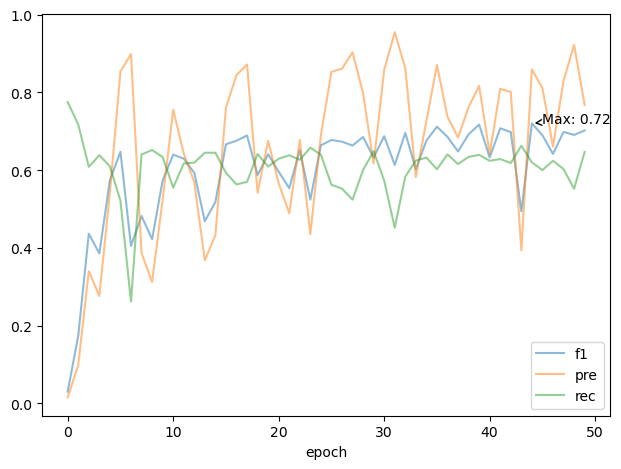

In [11]:
train(u_model1, u_optimizer1, [ckp, ckp_mng], dir_ckp,
      sub_train, sub_test,
      epochs=50, initial_epoch=0)

In [ ]:
res_acc = pd.read_csv(os.path.join(dir_root, 'loss.csv'))

plotAcc(res_acc, os.path.join(dir_root, 'loss.png'))

In [18]:
with open(os.path.join(dir_ckp, 'best.txt'), 'w') as f: 
  f.write(ckp_mng.latest_checkpoint)

# Evaluation

In [10]:
with open(os.path.join(dir_ckp, 'best.txt'), 'r') as f:
    best_ckp_path = f.readline()
    
# ckp.restore(ckp_mng.latest_checkpoint)
# ckp.restore(os.path.join(dir_ckp, 'best-17'))
ckp.restore(best_ckp_path)
print('Loaded best ckp: ', best_ckp_path)

Loaded best ckp:  Result\UNet4_sub8\ckp\best-16


In [11]:
def evaluateTfr(tf_model, tfr_path, dir_output):

    test_acc = tf.keras.metrics.CategoricalAccuracy()
    test_tp = tf.keras.metrics.TruePositives()
    test_fp = tf.keras.metrics.FalsePositives()
    test_fn = tf.keras.metrics.FalseNegatives()

    test_batch = input_pipeline(tfr_path, BATCH_SIZE,
                                is_train=False, is_shuffle=False, is_stand=True)

    for test_img, test_lab in test_batch:
        test_mask = test_lab[...,-1]
        test_lab = test_lab[...,-2] # binary here

        logits = tf_model(test_img, training=False)
        logits = tf.nn.softmax(logits)
        logits = tf.cast(tf.math.argmax(logits, axis = -1), tf.float32)
        logits = logits * test_mask

        test_acc.update_state(test_lab, logits)
        test_tp.update_state(test_lab, logits)
        test_fp.update_state(test_lab, logits)
        test_fn.update_state(test_lab, logits)

    np_acc = test_acc.result().numpy() * 100
    np_f1, np_pre, np_rec = computeKerasF1Score(test_tp, test_fp, test_fn)

    test_acc.reset_state()
    test_tp.reset_state()
    test_fp.reset_state()
    test_fn.reset_state()

    print('\n========Evaluation ========\n'+
          f'test  accuracy = {np_acc:.2f}\n'+
          f'f1 = {np_f1:.4f}\n'+
          f'pre = {np_pre:.4f}\n'+
          f'rec = {np_rec:.4f}')


    if len(tfr_path) > 1: 
        cur_name = 'All_region'
    else: 
        cur_name = os.path.basename(tfr_path[0]).split('.')[0]
    cur_res = pd.DataFrame([[cur_name, np_acc, np_f1, np_pre, np_rec]], 
                           columns=['Name', 'acc',' f1', 'pre', 'rec'])
    
    output_path = os.path.join(dir_output, 'eval.csv')
    if os.path.exists(output_path): 
        pd_res = pd.read_csv(output_path)
        pd_res = pd.concat([pd_res, cur_res], ignore_index=True)
    else: 
        pd_res = cur_res
    pd_res.to_csv(output_path, index=False)
  

def plotResult(ls_img, title, output_name=''):

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(ls_img[0])
    plt.title('RGB', fontsize=15)

    plt.subplot(1, 3, 2)
    plt.imshow(ls_img[1])
    plt.title('True', fontsize=15)

    plt.subplot(1, 3, 3)
    plt.imshow(ls_img[2])
    plt.title('Pred', fontsize=15)

    plt.suptitle(title, fontsize=15)
    plt.subplots_adjust(top=0.8)

    plt.tight_layout()
    if len(output_name) > 0:
        plt.savefig(output_name)
        plt.close()
    else:
        plt.show()

def plotTfr(tf_model, tfr_path, dir_output='', n_plot_skip=2):
    cur_name = os.path.basename(tfr_path).split('.')[0]

    test_tp = tf.keras.metrics.TruePositives()
    test_fp = tf.keras.metrics.FalsePositives()
    test_fn = tf.keras.metrics.FalseNegatives()

    test_batch = input_pipeline(tfr_path, BATCH_SIZE,
                                is_train=False, is_shuffle=False, is_stand=True)
    test_batch_vis = input_pipeline(tfr_path, BATCH_SIZE,
                                is_train=False, is_shuffle=False, is_stand=False)

    num_count = 0
    for (test_img, test_lab), (vis_img, _) in zip(test_batch, test_batch_vis):

        # only plot positive samples
        pst_idx = tf.reduce_sum(test_lab[...,-2], axis=(1,2)) > 0
        if tf.reduce_any(pst_idx):
          test_mask = test_lab[pst_idx]
          test_lab = test_lab[pst_idx]
          test_img = test_img[pst_idx]
          vis_img = vis_img[pst_idx]
        else: 
          continue 

        test_mask = test_lab[::n_plot_skip,...,-1]
        test_lab = test_lab[::n_plot_skip,...,-2]
        test_img = test_img[::n_plot_skip]
        vis_img = vis_img[::n_plot_skip]

        logits = tf_model(test_img, training=False)
        logits = tf.nn.softmax(logits)
        logits = tf.cast(tf.math.argmax(logits, axis = -1), tf.float32)
        logits = logits * test_mask

        for i in range(logits.shape[0]):
          test_tp.update_state(test_lab[i], logits[i])
          test_fp.update_state(test_lab[i], logits[i])
          test_fn.update_state(test_lab[i], logits[i])

          np_f1, np_pre, np_rec = computeKerasF1Score(test_tp, test_fp, test_fn)

          cur_title = 'f1=%.2f, p=%.2f, t=%.2f'%(np_f1, np_pre, np_rec)
          cur_imgs = [vis_img[i].numpy().astype(np.int_), test_lab[i].numpy(), logits[i].numpy()]
          if len(dir_output) > 0:
            output_name = os.path.join(dir_output, cur_name+'_'+str(num_count).zfill(2)+'.png')
            cur_title = cur_name + '\n' + cur_title
            plotResult(cur_imgs, cur_title, output_name)
            num_count += 1
          else: 
            plotResult(cur_imgs, cur_title)

          test_tp.reset_state()
          test_fp.reset_state()
          test_fn.reset_state()


In [12]:
ls_test_path = glob(os.path.join(DIR_INPUT, 'test*.tfrecords'))
ls_test_path[:5]

['TrainData\\TFR\\test_2019-06-03_2.tfrecords',
 'TrainData\\TFR\\test_2019-06-03_4.tfrecords',
 'TrainData\\TFR\\test_2019-06-03_6.tfrecords',
 'TrainData\\TFR\\test_2019-06-19_1.tfrecords',
 'TrainData\\TFR\\test_2019-06-19_3.tfrecords']

In [13]:
evaluateTfr(u_model1, ls_test_path, dir_root)


========Evaluation ========
test  accuracy = 97.74
f1 = 0.4858
pre = 0.4890
rec = 0.4827


In [14]:
for single_site in ls_test_path:
  evaluateTfr(u_model1, [single_site], dir_root)
  print(single_site)


========Evaluation ========
test  accuracy = 96.11
f1 = 0.3725
pre = 0.7197
rec = 0.2513
TrainData\TFR\test_2019-06-03_2.tfrecords

========Evaluation ========
test  accuracy = 98.58
f1 = 0.1167
pre = 0.8087
rec = 0.0629
TrainData\TFR\test_2019-06-03_4.tfrecords

========Evaluation ========
test  accuracy = 98.95
f1 = 0.0620
pre = 0.0334
rec = 0.4269
TrainData\TFR\test_2019-06-03_6.tfrecords

========Evaluation ========
test  accuracy = 95.86
f1 = 0.4346
pre = 0.8898
rec = 0.2875
TrainData\TFR\test_2019-06-19_1.tfrecords

========Evaluation ========
test  accuracy = 95.87
f1 = 0.6718
pre = 0.8279
rec = 0.5653
TrainData\TFR\test_2019-06-19_3.tfrecords

========Evaluation ========
test  accuracy = 98.64
f1 = 0.4770
pre = 0.9071
rec = 0.3235
TrainData\TFR\test_2019-06-19_5.tfrecords

========Evaluation ========
test  accuracy = 94.75
f1 = 0.5926
pre = 0.7550
rec = 0.4878
TrainData\TFR\test_2019-07-31_2.tfrecords

========Evaluation ========
test  accuracy = 97.98
f1 = 0.3146
pre = 0.2029

In [16]:
dir_fig = os.path.join(dir_root, 'fig')
if not os.path.exists(dir_fig):
    os.makedirs(dir_fig)

for single_site in ls_test_path:
  print(single_site)
  plotTfr(u_model1, single_site, dir_fig, n_plot_skip=1)


TrainData\TFR\test_2019-06-03_2.tfrecords
TrainData\TFR\test_2019-06-03_4.tfrecords
TrainData\TFR\test_2019-06-03_6.tfrecords
TrainData\TFR\test_2019-06-19_1.tfrecords
TrainData\TFR\test_2019-06-19_3.tfrecords
TrainData\TFR\test_2019-06-19_5.tfrecords
TrainData\TFR\test_2019-07-31_2.tfrecords
TrainData\TFR\test_2019-07-31_4.tfrecords
TrainData\TFR\test_2019-07-31_6.tfrecords
TrainData\TFR\test_2019-08-25_1.tfrecords
TrainData\TFR\test_2019-08-25_3.tfrecords
TrainData\TFR\test_2019-08-25_5.tfrecords


In [ ]:
plotTfr(u_model, ls_test_path[:1])

## Mosiac

In [17]:
import rasterio
from rasterio.features import shapes as RSHAPES
import cv2
import geopandas as gpd
import shapely

In [18]:
dir_img = os.path.join('TrainData', 'Processed')
ls_img_path = glob(os.path.join(dir_img, '*.tif'))
ls_img_path.sort()

dir_geo_tif = os.path.join(dir_root, 'geo', 'tif')
if not os.path.exists(dir_geo_tif): 
  os.makedirs(dir_geo_tif)

dir_geo_plg = os.path.join(dir_root, 'geo', 'plg')
if not os.path.exists(dir_geo_plg): 
  os.makedirs(dir_geo_plg)

In [19]:
def predictTiff(tf_model, cur_img_path): 

  with rasterio.open(cur_img_path) as src:
    cur_data = [src.read(i+1) for i in range(3)]
    meta = src.meta
    
  cur_data = np.stack(cur_data, axis=-1)
  cur_mask = np.all(cur_data == [0,0,0], axis=-1)
  cur_mask = ~cur_mask

  img_xsize = cur_data.shape[0]
  img_ysize = cur_data.shape[1]


  ## ------ predict ------
  res_lab = np.zeros((img_xsize, img_ysize), dtype=np.bool_)
  step_x = IMG_WIDTH // 2
  step_y = IMG_HEIGHT // 2

  # fill boundary 1
  for x in [0, img_xsize-IMG_HEIGHT]: 
    for y in range(0, img_ysize-IMG_WIDTH+1, IMG_WIDTH):
      x1 = x + IMG_HEIGHT
      y1 = y + IMG_WIDTH
      
      if np.sum(cur_mask[x:x1, y:y1]) == 0: 
        continue 
      
      cur_x = tf.image.per_image_standardization(cur_data[x:x1, y:y1])
      cur_pred = tf_model(tf.expand_dims(cur_x, axis=0), training=False)
      cur_pred = tf.cast(tf.argmax(cur_pred[0], axis=-1), tf.bool).numpy()

      res_lab[x:x1, y:y1] = cur_pred

  # fill boundary 2
  for y in [0, img_ysize-IMG_WIDTH]: 
    for x in range(0, img_xsize-IMG_HEIGHT+1, IMG_HEIGHT):
      x1 = x + IMG_HEIGHT
      y1 = y + IMG_WIDTH
      
      if np.sum(cur_mask[x:x1, y:y1]) == 0: 
        continue 
      
      cur_x = tf.image.per_image_standardization(cur_data[x:x1, y:y1])
      cur_pred = tf_model(tf.expand_dims(cur_x, axis=0), training=False)
      cur_pred = tf.cast(tf.argmax(cur_pred[0], axis=-1), tf.bool).numpy()

      res_lab[x:x1, y:y1] = cur_pred

  # fill center
  x_flag = True
  for x in range(0, img_xsize, step_x): 
    ls_x = []
    ls_y_idx = []
    y_flag = True 
    for y in range(0, img_ysize, step_y):
      x1 = x + IMG_HEIGHT
      y1 = y + IMG_WIDTH
      
      if x1 > img_xsize:
        if x_flag: 
          x1 = img_xsize
          x = x1 - IMG_HEIGHT
          x_flag = False
        else: 
          continue
      if y1 > img_ysize:
        if y_flag: 
          y1 = img_ysize
          y = y1 - IMG_WIDTH
          y_flag = False
        else: 
          continue
      
      if np.sum(cur_mask[x:x1, y:y1]) == 0: 
        continue 
      
      ls_y_idx.append(y)       
      cur_x = tf.image.per_image_standardization(cur_data[x:x1, y:y1])
      ls_x.append(tf.expand_dims(cur_x, axis=0))
    
    
    if len(ls_x) > 0: 
      ls_x = tf.concat(ls_x, axis=0)
      ls_x = tf.data.Dataset.from_tensor_slices(ls_x)
      ls_x = ls_x.batch(100)
      
      ls_y = []
      for cur_x_ds in ls_x: 
        cur_pred = tf_model(cur_x_ds, training=False)
        cur_pred = tf.cast(tf.argmax(cur_pred, axis=-1), tf.bool)
        ls_y.append(cur_pred)
      ls_y = tf.concat(ls_y, axis=0).numpy()
          
      for i in range(len(ls_y_idx)):
        y = ls_y_idx[i]
        y1 = y + IMG_WIDTH
        
        res_lab[x+int(step_x/2):x1-int(step_x/2), y+int(step_y/2):y1-int(step_y/2)] = ls_y[i][int(step_x/2):int(step_x/2)+step_x, int(step_y/2):int(step_y/2)+step_y]

    else: 
      continue

  res_lab = np.logical_and(res_lab, cur_mask)
  res_meta = meta.copy()
  res_meta.update({
    'nodata': None,
    'count': 1,
    })

  return res_lab, res_meta


def imgMph(img, kernel_size): 
  kernel = np.ones((kernel_size, kernel_size),np.uint8)
  
  res = img.astype(float)
  res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel)
  res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel)
  
  return res.astype(np.uint8)


def img2gdf(np_img, rs_trs, rs_crs, res_name): 
  res_polygon = RSHAPES(np_img, np_img==1, transform=rs_trs)

  ls_geo = []
  for geom, _ in res_polygon:
    ls_geo.append(shapely.geometry.shape(geom))

  gdf = gpd.GeoDataFrame(geometry=ls_geo)
  gdf.crs = rs_crs
  gdf['Area'] = gdf.area
  
  gdf_name = generateOfficialName(res_name.split('_roi')[0])
  gdf_roi = int(res_name.split('_roi')[1][:1]) + 1
  gdf['image'] = gdf_name
  gdf['region_num'] = gdf_roi
  gdf = gdf[['image', 'region_num', 'geometry', 'Area']] # remove Area column before submission
  
  return gdf


def generateOfficialName(str_date):
  NAME_PREFIX = 'Greenland26X_22W_Sentinel2_'
  LS_NAME_SUFFIX = ['_05.tif', '_20.tif', '_25.tif', '_29.tif']
  
  gdf_name = str_date
  if gdf_name == '2019-06-03':
    gdf_name += LS_NAME_SUFFIX[0]
  elif gdf_name == '2019-06-19':
    gdf_name += LS_NAME_SUFFIX[1]
  elif gdf_name == '2019-07-31':
    gdf_name += LS_NAME_SUFFIX[2]
  elif gdf_name == '2019-08-25':
    gdf_name += LS_NAME_SUFFIX[3]
  else: 
    print('Wrong image date detected!')
  gdf_name = NAME_PREFIX + gdf_name
  return gdf_name


def removeOverlay(gdf):
  mask = pd.Series([True] * len(gdf), index=gdf.index)

  for i, poly1 in enumerate(gdf.geometry):
      for j, poly2 in enumerate(gdf.geometry):
          if i != j and poly1.overlaps(poly2):
              mask[i] = False
              break
  
  out = gdf[mask]
  if len(out) != len(gdf): 
    print(f'Found {len(gdf)-len(out)} overlaid polygons. Removed..')
  return out


def computeF1_GPD(gdf_true, gdf_pred):
  tp = 0
  fp = 0
  fn = 0

  threshold = 0.5
  for poly1 in gdf_true.geometry:
      match_found = False
      for poly2 in gdf_pred.geometry:
          overlap_area = poly1.intersection(poly2).area
          
          if overlap_area / poly1.area > threshold:
              match_found = True
              tp += 1
              break
      if not match_found:
          fn += 1

  for poly2 in gdf_pred.geometry:
      if not any(poly1.intersection(poly2).area / poly1.area > threshold for poly1 in gdf_true.geometry):
          fp += 1

  precision = tp / (tp + fp) if tp + fp > 0 else 0
  recall = tp / (tp + fn) if tp + fn > 0 else 0
  f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
  
  # print(f"F1 Score: {f1_score:.4f}")
  return f1_score


In [44]:
res_gdf

,image,region_num,geometry,Area
0,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,4,"POLYGON ((-5647282.305 9903219.603, -5647129.4...",153368.756443
1,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,4,"POLYGON ((-5516269.239 9902225.922, -5516269.2...",1460.654823
2,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,4,"POLYGON ((-5516192.802 9902264.140, -5516192.8...",4381.964470
3,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,4,"POLYGON ((-5548372.791 9901194.022, -5548219.9...",248311.319955
4,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,4,"POLYGON ((-5520549.712 9900123.903, -5520511.4...",211794.949374
...,...,...,...,...
551,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,4,"POLYGON ((-5520931.897 9574731.474, -5520931.8...",1460.654823
552,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,4,"POLYGON ((-5521084.772 9574807.911, -5521046.5...",65729.467047
553,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,4,"POLYGON ((-5520931.897 9574655.037, -5520931.8...",1460.654823
554,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,4,"POLYGON ((-5521810.923 9567546.393, -5521810.9...",1460.654823


In [47]:
cur_img_path

'TrainData\\Processed\\2019-06-03_roi3.tif'

In [48]:
cur_name = os.path.basename(cur_img_path)
output_name = os.path.join(dir_geo_tif, 'pred_'+cur_name)


# predic
if not os.path.exists(output_name):
  res_lab, res_meta = predictTiff(u_model1, cur_img_path)
  with rasterio.open(output_name, "w", **res_meta) as dest:
    dest.write(res_lab.astype(np.uint8), 1)

with rasterio.open(output_name) as src:
  res_lab = src.read(1)
  res_meta = src.meta
  res_transform = src.transform
  res_crs = src.crs
res_gdf = img2gdf(res_lab, res_transform, res_crs, cur_name)
res_gdf = removeOverlay(res_gdf)

In [58]:
inp_gdf = gpd.read_file(os.path.join('TrainData', 'lake_polygons_training.gpkg'))

ls_f1 = []
for cur_img_path in tqdm(ls_img_path): 
  cur_name = os.path.basename(cur_img_path)
  output_name = os.path.join(dir_geo_tif, 'pred_'+cur_name)


  # predic
  if not os.path.exists(output_name):
    res_lab, res_meta = predictTiff(u_model1, cur_img_path)
    with rasterio.open(output_name, "w", **res_meta) as dest:
      dest.write(res_lab.astype(np.uint8), 1)

  with rasterio.open(output_name) as src:
    res_lab = src.read(1)
    res_meta = src.meta
    res_transform = src.transform
    res_crs = src.crs
  res_gdf = img2gdf(res_lab, res_transform, res_crs, cur_name)
  res_gdf = removeOverlay(res_gdf)
      
  gdf_true = inp_gdf[(inp_gdf.image==res_gdf.image.unique()[0])&(inp_gdf.region_num==res_gdf.region_num.unique()[0])]
  cur_f1 = computeF1_GPD(gdf_true, res_gdf)
  
  gdf_name = 'pred_'+cur_name.split('.')[0]+'_f1-'+str(cur_f1)[2:6]+'.gpkg'
  res_gdf.to_file(os.path.join(dir_geo_plg, gdf_name), driver="GPKG")
  ls_f1.append([cur_name, 0, cur_f1])
  
  
  # post processing
  ls_kernel = [3, 5, 7, 10, 15, 20, 30]
  for kernel_size in ls_kernel: 
    res_post = imgMph(res_lab, kernel_size)
  
    output_name = os.path.join(dir_geo_tif, 'pred_'+cur_name.split('.')[0]+'_s'+str(kernel_size).zfill(2)+'.tif')
    with rasterio.open(output_name, "w", **res_meta) as dest:
        dest.write(res_post, 1)
        
    res_gdf = img2gdf(res_post, res_transform, res_crs, cur_name)
    res_gdf = removeOverlay(res_gdf)

    if len(res_gdf) > 0: 
      gdf_true = inp_gdf[(inp_gdf.image==res_gdf.image.unique()[0])&(inp_gdf.region_num==res_gdf.region_num.unique()[0])]
      cur_f1 = computeF1_GPD(gdf_true, res_gdf)
      
      gdf_name = 'pred_'+cur_name.split('.')[0]+'_s'+str(kernel_size).zfill(2)+'_f1-'+str(cur_f1)[2:6]+'.gpkg'
      res_gdf.to_file(os.path.join(dir_geo_plg, gdf_name), driver="GPKG")
    else: 
      cur_f1 = 0
    ls_f1.append([cur_name, kernel_size, cur_f1])    

ls_f1 = pd.DataFrame(ls_f1, columns=['name', 'kernel', 'f1'])
ls_f1.to_csv(os.path.join(dir_geo_plg, 'all.csv'), index=False)

  4%|▍         | 1/24 [00:41<15:47, 41.18s/it]c:\Users\zhwang1\Anaconda3\envs\tf\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\zhwang1\Anaconda3\envs\tf\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\zhwang1\Anaconda3\envs\tf\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\zhwang1\Anaconda3\envs\tf\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\zhwang1\Anaconda3\envs\tf\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\zhwang1\Anaconda3\envs\tf

In [26]:
def plotSmoothF1(ls_f1, output_path=''): 
  fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
  for i in range(4): 
    for j in range(6):
      cur_name = ls_f1.name.unique().tolist()[i*6+j]
      cur_stat = ls_f1[ls_f1.name == cur_name]
      if cur_stat.f1.sum() == 0: 
        continue
      cur_stat.plot.bar(ax=axes[i,j//2], x='kernel', y='f1', 
                        color=['red' if idx == cur_stat.f1.idxmax() else 'blue' for idx in cur_stat.index], 
                        ylim=(0,0.8))
      axes[i,j//2].set_title(cur_name)
  plt.tight_layout()
  if len(output_path) > 0: 
    plt.savefig(os.path.join(output_path, 'all_fig'))

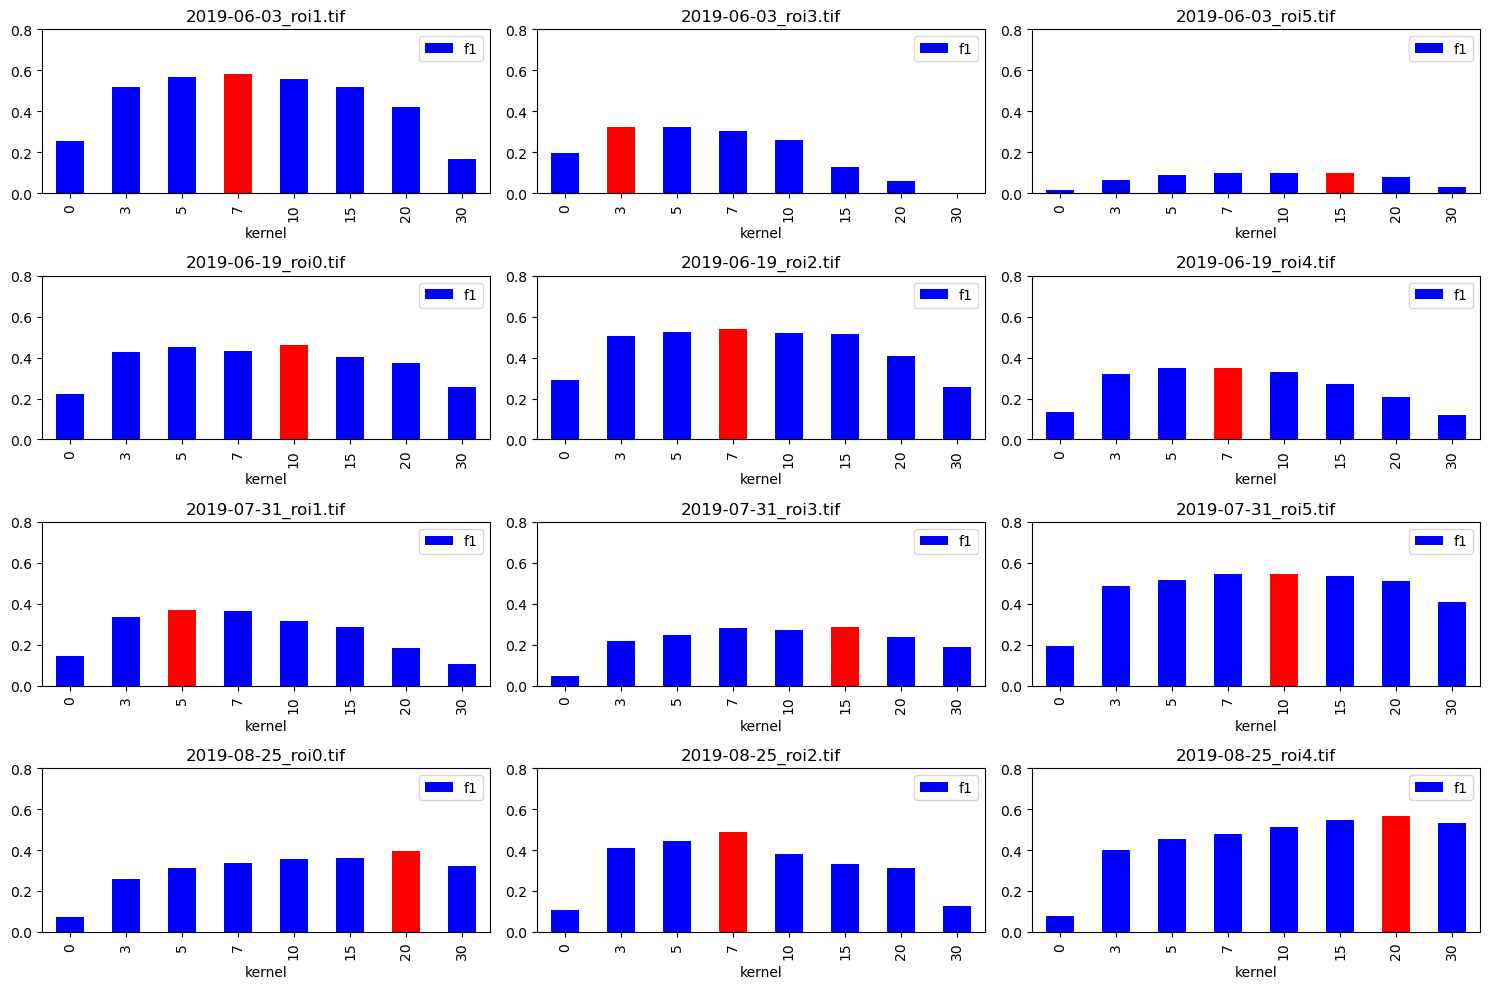

In [59]:
plotSmoothF1(ls_f1, dir_geo_plg)


In [ ]:
ls_f1 = pd.read_csv(os.path.join(dir_geo_plg, 'all.csv'))

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
for i in range(4): 
  for j in range(6):
    cur_name = ls_f1.name.unique().tolist()[i*6+j]
    cur_stat = ls_f1[ls_f1.name == cur_name]
    if cur_stat.f1.sum() == 0: 
      continue
    cur_stat.plot.bar(ax=axes[i,j//2], x='kernel', y='f1', 
                      color=['red' if idx == cur_stat.f1.idxmax() else 'blue' for idx in cur_stat.index], 
                      ylim=(0,0.8))
    axes[i,j//2].set_title(cur_name)
plt.tight_layout()
plt.savefig(os.path.join(dir_geo_plg, 'all_fig'))